In [ ]:
!pip install tensorflow
!pip install --upgrade tensorflow

!pip install transformers -q
!pip install --upgrade transformers
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
!pip install ipywidgets


  Using cached tensorflow-2.12.0-cp311-cp311-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp311-cp311-win_amd64.whl (272.9 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
      --------------------------------------- 0.0/2.6 MB 1.9 MB/s eta 0:00:02
     - -------------------------------------- 0.1/2.6 MB 1.2 MB/s eta 0:00:03
     -- ------------------------------------- 0.2/2.6 MB 1.4 MB/s eta 0:00:02
     --- ------------------------------------ 0.2/2.6 MB 1.2 MB/s eta 0:00:02
     ----- ---------------------------------- 0.3/2.6 MB 1.6 MB/s eta 0:00:02
     ------- -------------------------------- 0.5/2.6 MB 1.8 MB/s eta 0:00:02
     --------- ------------------------------ 0.6/2.6 MB 2.0 MB/s eta 0:00:02
     ----------- ---------------------------- 0.7/2.6 MB 2.1 MB/s eta 0:00:01
     ------------ --------------------------- 0.8/2.6 

In [ ]:
from transformers import BertModel, BertTokenizerFast

alephbert_tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
alephbert = BertModel.from_pretrained('onlplab/alephbert-base')

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias

In [ ]:
import sys
import codecs
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn, optim
from collections import defaultdict
from sklearn.metrics import classification_report
from transformers import AdamW, get_linear_schedule_with_warmup

In [2]:
df = pd.read_csv('training_new.csv')
df = df.drop('Unnamed: 0',axis = 1)
print(display(df.head()))

,motion_id,emotion,emotion_en,talkbacks
0,0,כעס,anger,לא הרגשתי מושפל
1,0,כעס,anger,אני יכול לעבור מתחושה כל כך חסרת תקווה לכל כך ...
2,3,אהבה,love,אני תופס דקה לפרסם אני מרגיש טועה בחמדנות
3,2,שמחה,joy,"אני אי פעם מרגיש נוסטלגי לגבי האח, אדע שהוא עד..."
4,3,אהבה,love,אני מרגיש עצבני


None


<Axes: xlabel='emotion_en', ylabel='count'>

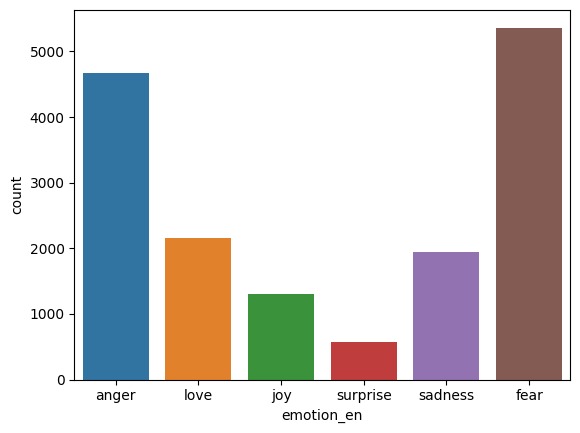

In [3]:
sns.countplot(x='emotion_en',data=df)

In [ ]:
df_val = pd.read_csv('validation_new.csv')
df_val = df_val.drop('Unnamed: 0',axis = 1)
print(display(df_val.head()))

,motion_id,emotion,emotion_en,talkbacks
0,0,כעס,anger,אני מרגיש די עצוב ומצטער על עצמי אבל אני חולה ...
1,0,כעס,anger,אני מרגיש כאילו אני עדיין מסתכל על פיסות נייר ...
2,2,שמחה,joy,אני מרגיש כמו משרת נאמן
3,3,אהבה,love,אני פשוט מרגיש עצבני וכחול
4,1,פחד,fear,אני יכול לקבל פינוק או אם אני מרגיש חגיגי


None


In [ ]:
train_tokens = df.talkbacks
train_tokens = train_tokens.to_numpy()
train_tags = df.motion_id
train_tags = train_tags.to_numpy()

test_tokens = df_val.talkbacks
test_tokens = test_tokens.to_numpy()
test_tags = df_val.motion_id
test_tags = test_tags.to_numpy()


In [ ]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(review, add_special_tokens=True, max_length=self.max_len, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt',)
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
def create_data_loader(df,df_tags, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        #reviews=df.to_numpy(),
        #targets=df_tags.to_numpy(),
        reviews=df,
        targets=df_tags,   
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
        ds,
        batch_size=batch_size,
        #windows
        num_workers=0
        #colab
        #num_workers=4
      )

In [ ]:
def loader(x_train, y_tags, x_test, y_test, MAX_LEN, BATCH_SIZE):
    train_data_loader = create_data_loader(x_train, y_tags, alephbert_tokenizer, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(x_test,y_test, alephbert_tokenizer, MAX_LEN, BATCH_SIZE)
    return train_data_loader, val_data_loader

In [ ]:
def getmodel(class_names, device, classifier):
    model = classifier(len(class_names))
    model = model.to(device)
    return model

In [ ]:
class EmotionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EmotionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('onlplab/alephbert-base', return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.drop1 = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        output = self.drop(pooled_output)
        output = self.out1(output)
        output = self.relu(output)
        output = self.drop1(output)
        return self.out(output)

In [ ]:
def opsclo(model, train_data_loader,EPOCHS , device):
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )
    loss_fn = nn.CrossEntropyLoss().to(device)
    return optimizer, scheduler, loss_fn

In [ ]:
def train_epoch(model, data_loader,  loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(EPOCHS,model,train_loader,val_loader, loss_fn,optimizer,device, scheduler,X_train, X_test ,nametomodel):
    history = defaultdict(list)
    best_accuracy = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, len(X_train))
        print(f'Train loss {train_loss} accuracy {train_acc}')
        val_acc, val_loss = eval_model(model, val_loader, loss_fn, device, len(X_test))
        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), nametomodel)
            best_accuracy = val_acc
    return history

In [ ]:
def class_name(df):
    class_n = df.copy()
    class_n = class_n[['emotion_en','motion_id']]
    class_n = class_n.drop_duplicates()
    class_n = class_n.sort_values(by=['motion_id'])
    class_n = class_n.emotion_en
    class_n.reset_index(drop=True, inplace=True)
    return class_n

In [ ]:
def plot(history):
    if history['train_acc'][0].device.__eq__('cuda:0'):
        train_acc = torch.tensor(history['train_acc']).cpu().numpy()
        val_acc = torch.tensor(history['val_acc']).cpu().numpy()
    else:
        train_acc = history['train_acc']
        val_acc = history['val_acc']    
    plt.plot(train_acc, label='train accuracy')
    plt.plot(val_acc, label='validation accuracy')
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1])  

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
%%time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 16
MAX_LEN = 200
EPOCHS = 10
train_data_loader, val_data_loader = loader(train_tokens, train_tags,test_tokens,test_tags, MAX_LEN, BATCH_SIZE)
class_names = class_name(df)
model = getmodel(class_names, device, EmotionClassifier)
optimizer, scheduler, loss_fn = opsclo(model, train_data_loader,EPOCHS , device)
nametomodel = 'best_model_state_emotion.bin'
history = train_model(EPOCHS,model,train_data_loader,val_data_loader, loss_fn,optimizer,device, scheduler,train_tokens, test_tokens,nametomodel)

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias

Epoch 1/10
----------
Train loss 0.8253816610127688 accuracy 0.719875
Val   loss 0.5025847349762916 accuracy 0.8355

Epoch 2/10
----------
Train loss 0.39302434349618853 accuracy 0.8705625
Val   loss 0.4986775393933058 accuracy 0.8475

Epoch 3/10
----------
Train loss 0.26852470741886647 accuracy 0.9129375000000001
Val   loss 0.5532608847282827 accuracy 0.852

Epoch 4/10
----------
Train loss 0.19344364353246055 accuracy 0.93775
Val   loss 0.6476142009682954 accuracy 0.8445

Epoch 5/10
----------
Train loss 0.14729217702383177 accuracy 0.95775
Val   loss 0.7497889784872532 accuracy 0.844

Epoch 6/10
----------
Train loss 0.10631553851126227 accuracy 0.971375
Val   loss 0.83581717571849 accuracy 0.852

Epoch 7/10
----------
Train loss 0.08360967610834633 accuracy 0.97975
Val   loss 0.9758575297528878 accuracy 0.846

Epoch 8/10
----------
Train loss 0.07052311236289097 accuracy 0.983125
Val   loss 0.9546624127931427 accuracy 0.845

Epoch 9/10
----------
Train loss 0.04512703258154215 acc

C:\Users\Naors\AppData\Local\Temp\ipykernel_27472\259476092.py:2: DeprecationWarning: NotImplemented should not be used in a boolean context
  if history['train_acc'][0].device.__eq__('cuda:0'):


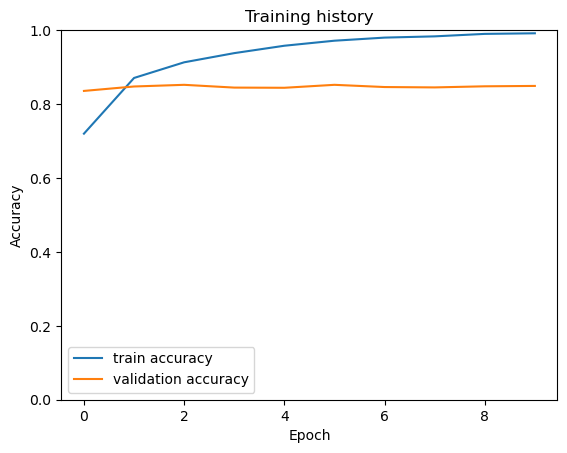

In [ ]:
plot(history)

In [ ]:
model.load_state_dict(torch.load(nametomodel))
df_insample = pd.read_csv('test_new.csv')
df_insample = df_insample.drop('Unnamed: 0',axis = 1)
print(display(df_insample.head()))
X_test_insample = df_insample.talkbacks
X_test_insample = X_test_insample.to_numpy()
Y_test_insample = df_insample.motion_id
Y_test_insample = Y_test_insample.to_numpy()
test_data_loader_insample = create_data_loader(X_test_insample,Y_test_insample, alephbert_tokenizer, MAX_LEN, BATCH_SIZE)
test_insample_acc, test_insample_loss = eval_model(model, test_data_loader_insample, loss_fn, device, len(X_test_insample))
print(f'test insample loss {test_insample_loss} accuracy {test_insample_acc}')

,motion_id,emotion,emotion_en,talkbacks
0,0,כעס,anger,אני מרגיש די רקוב אז אני לא מאוד שאפתני כרגע
1,0,כעס,anger,אני מעדכן את הבלוג שלי כי אני מרגיש מחורבן
2,0,כעס,anger,אני אף פעם לא גורם לה להיפרד ממני כי אני אף פע...
3,1,פחד,fear,עזבתי עם זר הצבעונים האדום והצהוב שלי מתחת לזר...
4,0,כעס,anger,הרגשתי קצת שווא כשעשיתי את זה


None


C:\Users\Naors\anaconda3\envs\tf-n-gpu\Lib\site-packages\transformers\tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


test insample loss 0.5577799650505185 accuracy 0.8515


In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader_insample)
print('\nClassification Report test insample:\n\n',classification_report(y_test, y_pred, target_names=class_names))


Classification Report test insample:

               precision    recall  f1-score   support

       anger       0.93      0.88      0.90       581
        fear       0.89      0.91      0.90       695
         joy       0.73      0.65      0.69       159
        love       0.80      0.83      0.82       275
     sadness       0.73      0.86      0.79       224
    surprise       0.74      0.53      0.62        66

    accuracy                           0.85      2000
   macro avg       0.80      0.78      0.79      2000
weighted avg       0.85      0.85      0.85      2000

